<a href="https://colab.research.google.com/github/lechemrc/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
from collections import namedtuple

User = namedtuple('User', ['purchased', 'time_on_site', 'mobile'])
example_user = User(False, 12, False)
example_user

User(purchased=False, time_on_site=12, mobile=False)

In [3]:
example_user.time_on_site=30

AttributeError: ignored

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

In [7]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes (600 sec) on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  # time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60) # based on ecommerce data from 2016
  purchased = random.random() < 0.1 + (time_on_site / 1500) # 15 sec x 100%
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  # time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2.5*60)# based on ecommerce data from 2016
  purchased = random.random() < 0.3 + (time_on_site / 1500) 
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users) # shuffling is just good practice, especially for predictive modeling
users[:10]

[User(purchased=True, time_on_site=905.8462367038433, mobile=False),
 User(purchased=True, time_on_site=265.0447669283984, mobile=False),
 User(purchased=False, time_on_site=345.90492486026125, mobile=True),
 User(purchased=True, time_on_site=19.540666540176346, mobile=True),
 User(purchased=True, time_on_site=219.71073152374757, mobile=True),
 User(purchased=False, time_on_site=464.3878967483892, mobile=True),
 User(purchased=True, time_on_site=511.4202653128014, mobile=False),
 User(purchased=False, time_on_site=270.0908650164447, mobile=False),
 User(purchased=True, time_on_site=443.97696747685774, mobile=True),
 User(purchased=False, time_on_site=242.28530066033306, mobile=True)]

In [8]:
import numpy as np

np.random.normal()

-1.0752032428982898

In [9]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,905.846237,False
1,True,265.044767,False
2,False,345.904925,True
3,True,19.540667,True
4,True,219.710732,True


In [10]:
user_data['time_on_site_min'] = user_data['time_on_site'] / 60
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,True,905.846237,False,15.097437
1,True,265.044767,False,4.417413
2,False,345.904925,True,5.765082
3,True,19.540667,True,0.325678
4,True,219.710732,True,3.661846


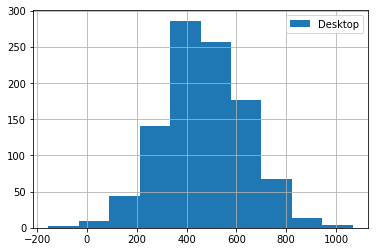

In [11]:
ax = user_data.time_on_site.hist()
ax.legend(['Desktop', 'Mobile']);

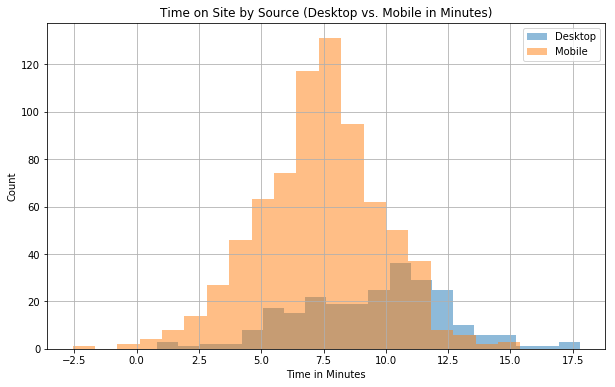

In [12]:
import matplotlib.pyplot as plt

user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5, figsize=(10,6))
plt.title('Time on Site by Source (Desktop vs. Mobile in Minutes)')
plt.ylabel('Count')
plt.xlabel('Time in Minutes')
plt.legend(['Desktop', 'Mobile']);

In [13]:
user_data[user_data['time_on_site'] < 0.0]

,purchased,time_on_site,mobile,time_on_site_min
354,False,-14.224914,True,-0.237082
666,False,-154.527535,True,-2.575459
937,False,-33.027001,True,-0.550450


In [41]:
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site'] = 0.0
user_data[user_data['time_on_site'] < 0.0]

,purchased,time_on_site,mobile,time_on_site_min


In [16]:
help(pd.crosstab)

Help on function crosstab in module pandas.core.reshape.pivot:

crosstab(index, columns, values=None, rownames=None, colnames=None, aggfunc=None, margins=False, margins_name='All', dropna=True, normalize=False)
    Compute a simple cross-tabulation of two (or more) factors. By default
    computes a frequency table of the factors unless an array of values and an
    aggregation function are passed
    
    Parameters
    ----------
    index : array-like, Series, or list of arrays/Series
        Values to group by in the rows
    columns : array-like, Series, or list of arrays/Series
        Values to group by in the columns
    values : array-like, optional
        Array of values to aggregate according to the factors.
        Requires `aggfunc` be specified.
    rownames : sequence, default None
        If passed, must match number of row arrays passed
    colnames : sequence, default None
        If passed, must match number of column arrays passed
    aggfunc : function, optional
 

In [17]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,0.0,10.80803146401064,19.540666540176346,36.88126020753771,48.824493878418025,57.108435566373714,60.3500308159708,66.10511536984603,74.77633457341568,90.13378041874677,95.03785088817682,96.47728192294659,104.65238187436046,105.02446140755126,106.72112330097116,108.73925776223695,110.84595295835118,116.72018408033722,117.68301638936629,118.44658642131441,128.3487642582425,128.36765719041261,132.7590740661882,145.36356771751832,149.10296070088356,160.12836202531014,160.4125253342495,161.27619257851268,162.17145123447597,163.83301075779917,165.61856879444719,169.9403856492512,170.04314702076096,170.59627209611193,171.99446856559484,172.35093571327099,174.25005451699207,177.41737429839407,178.42611675622294,180.35001346809008,...,755.4540396202215,760.2069923395026,762.5322278420724,763.3497314057397,764.3525335582347,764.422121170768,767.1575413309802,771.6169975933279,780.9004360236537,782.5216304466503,783.0213085168365,784.300795482613,790.8558577702614,793.6612396945548,797.7350840140389,801.0155216738198,809.6921779036429,811.0165837897702,814.785556704442,814.8438191398045,815.980694724936,818.6471222343637,825.0100469989629,825.708318869535,852.507793880796,862.2571936671305,864.9040990151727,870.2302037814534,881.8895199142164,894.6889820901018,900.710853206024,905.8462367038433,909.3729048042447,913.5470579891478,923.7722906743578,933.7230780049993,999.0161134277575,1021.7055997850946,1027.1078097573663,1067.226770413297
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,3,1,0,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
True,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,1,...,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,1


In [18]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site_min,,
"(-2.596, 1.497]",8,3
"(1.497, 5.57]",99,86
"(5.57, 9.642]",227,315
"(9.642, 13.715]",73,171
"(13.715, 17.787]",4,14


In [0]:
# above we haven't taken into account mobile or desktop


In [19]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-2.596, 1.497]",0.019465,0.005093
"(1.497, 5.57]",0.240876,0.146010
"(5.57, 9.642]",0.552311,0.534805
"(9.642, 13.715]",0.177616,0.290323
"(13.715, 17.787]",0.009732,0.023769


In [20]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.484,0.386667
True,0.516,0.613333


In [21]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')

purchased            False               True           
mobile               False     True      False     True 
time_on_site_min                                        
(-2.596, 1.497]   0.016529  0.020690  0.000000  0.006522
(1.497, 5.57]     0.132231  0.286207  0.077519  0.165217
(5.57, 9.642]     0.429752  0.603448  0.302326  0.600000
(9.642, 13.715]   0.388430  0.089655  0.534884  0.221739
(13.715, 17.787]  0.033058  0.000000  0.085271  0.006522

## Stanford Open Police Project

In [24]:
!unzip tr137st9964_tx_austin_2019_02_25.csv.zip
!ls

Archive:  tr137st9964_tx_austin_2019_02_25.csv.zip
  inflating: share/data/opp-for-archive/tx_austin_2019_02_25.csv  
sample_data  share  tr137st9964_tx_austin_2019_02_25.csv.zip


In [25]:
%%time
df = pd.read_csv('./share/data/opp-for-archive/tx_austin_2019_02_25.csv')
print(df.shape)


(435222, 20)
CPU times: user 1.65 s, sys: 200 ms, total: 1.85 s
Wall time: 1.85 s


In [26]:
df.head()

,raw_row_number,date,subject_age,subject_race,subject_sex,officer_id_hash,type,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_make,vehicle_model,vehicle_registration_state,vehicle_year
0,141,2006-01-07,53.0,white,female,59c9092a79,vehicular,NaN,NaN,NaN,NaN,True,True,True,probable cause,VIOLATION OF TRANSPORTATION/VEHICLE LAWS,STRN,NaN,TX,1996.0
1,4819,2006-03-21,21.0,white,male,46f8ed46eb,vehicular,NaN,NaN,NaN,NaN,False,False,False,NaN,VIOLATION OF TRANSPORTATION/VEHICLE LAWS,CADI,NaN,TX,2000.0
2,4820,2006-03-21,43.0,black,female,0d1d4fb150,vehicular,NaN,NaN,NaN,NaN,False,False,False,NaN,VIOLATION OF TRANSPORTATION/VEHICLE LAWS,KIA,NaN,TX,2003.0
3,4821,2006-04-20,46.0,hispanic,male,c70bca9788,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,VIOLATION OF CITY ORDINANCE,KW,NaN,TX,1994.0
4,4822,2006-03-21,25.0,white,male,e3f693e058,vehicular,NaN,NaN,NaN,NaN,False,False,False,NaN,VIOLATION OF TRANSPORTATION/VEHICLE LAWS,GMC,NaN,TX,2002.0


In [27]:
df.isna().sum()

raw_row_number                     0
date                               0
subject_age                    14767
subject_race                    2146
subject_sex                     7748
officer_id_hash                    0
type                           80175
contraband_found              427515
contraband_drugs              429512
contraband_weapons            429078
frisk_performed               422843
search_conducted               76844
search_person                  44596
search_vehicle                 73062
search_basis                  419155
reason_for_stop                    5
vehicle_make                    9396
vehicle_model                 297026
vehicle_registration_state     13040
vehicle_year                  110886
dtype: int64

In [28]:
df['type'].value_counts()

vehicular    355047
Name: type, dtype: int64

In [29]:
df['vehicle_make'].value_counts(normalize=True).head(10)  #normalize gives a percent, head(10) shows us the top 10

FORD    0.121042
CHEV    0.116792
TOYT    0.088987
HOND    0.080448
NISS    0.055123
DODG    0.047362
MAZD    0.030956
JEEP    0.021330
HYUN    0.018980
BUIC    0.018893
Name: vehicle_make, dtype: float64

In [30]:
df[df['vehicle_make'] == 'FORD']['subject_sex'].value_counts()

male      35921
female    14586
Name: subject_sex, dtype: int64

In [31]:
df['reason_for_stop'].value_counts()

VIOLATION OF TRANSPORTATION/VEHICLE LAWS                                                                                               339565
OTHER                                                                                                                                   32567
VIOLATION OF CITY ORDINANCE                                                                                                             29834
CALL FOR SERVICE                                                                                                                        13751
SUSPICIOUS PERSON / VEHICLE                                                                                                             13118
WATER SAFETY ACT                                                                                                                         2457
PRE-EXISTING KNOWLEDGE                                                                                                                   1393
VIOLAT

In [32]:
df = pd.DataFrame({'a': np.arange(1e6),
                  'b': 2*np.arange(1e6)})
print(df.shape)
df.head()

(1000000, 2)


,a,b
0,0.0,0.0
1,1.0,2.0
2,2.0,4.0
3,3.0,6.0
4,4.0,8.0


In [33]:
%timeit df['c'] = df['a'] ** 2

100 loops, best of 3: 15.8 ms per loop


In [34]:
%timeit df['c2'] = df['a'].apply(lambda x: x**2)

# if you were working with a larger data set, this time 
# difference would be much more impactful 

1 loop, best of 3: 319 ms per loop


In [35]:
from tqdm import tqdm # this gives you a progress bar functionality! 
tqdm.pandas()
%timeit df['c2'] = df['a'].progress_apply(lambda x: x**2)

100%|██████████| 1000000/1000000 [00:01<00:00, 705795.96it/s]

1 loop, best of 3: 1.42 s per loop


In [36]:
df.head()

,a,b,c,c2
0,0.0,0.0,0.0,0.0
1,1.0,2.0,1.0,1.0
2,2.0,4.0,4.0,4.0
3,3.0,6.0,9.0,9.0
4,4.0,8.0,16.0,16.0


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [1]:
!pip install pandas==0.23.4

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lechemrc/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', )
print(df.shape)
df.head()

(1200, 4)


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [4]:
age_bins = pd.cut(df['age'], 5)
weight_bins = pd.cut(df['weight'], 5)
exercise_bins = pd.cut(df['exercise_time'], 5)

pd.crosstab(weight_bins, df['exercise_time'])

# I've tried a few different combinations and I'm not totally sure what's it's
# showing me here. I'll try graphing a few things to see if I can make sense
# of the data here

exercise_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
weight,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(99.854, 129.2]",0,0,1,2,1,0,0,0,1,0,2,0,0,1,1,1,2,2,1,0,1,3,0,1,2,1,0,1,1,1,0,0,1,2,2,3,2,0,0,0,...,1,4,2,1,2,4,2,3,1,0,3,1,0,3,0,0,3,2,1,2,4,0,3,0,2,1,1,4,2,6,0,2,0,2,1,4,2,3,2,2
"(129.2, 158.4]",0,1,0,0,0,1,2,1,0,1,0,0,0,1,0,2,0,2,1,3,1,3,1,0,1,0,1,1,1,1,2,2,0,0,2,0,0,0,0,1,...,2,0,2,3,2,1,1,1,0,1,3,0,0,0,3,1,2,4,2,1,2,2,1,1,1,1,0,1,1,1,1,1,2,1,0,0,2,3,0,3
"(158.4, 187.6]",1,0,2,1,2,2,0,0,1,0,0,0,2,0,1,1,2,3,2,0,1,2,1,0,1,0,0,0,0,3,3,1,3,1,3,1,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"(187.6, 216.8]",1,2,2,0,2,1,2,0,0,2,2,0,0,3,1,1,1,3,1,1,2,3,4,0,1,1,0,2,2,1,3,0,1,1,0,1,3,5,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"(216.8, 246.0]",0,1,2,3,0,3,2,0,1,0,2,1,0,1,0,0,0,1,1,1,0,1,1,1,0,1,1,2,2,1,0,0,1,2,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
pd.crosstab(weight_bins, age_bins)

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
weight,,,,,
"(99.854, 129.2]",80,104,78,53,60
"(129.2, 158.4]",86,62,62,71,54
"(158.4, 187.6]",49,49,49,45,66
"(187.6, 216.8]",34,31,26,44,44
"(216.8, 246.0]",7,7,8,9,22


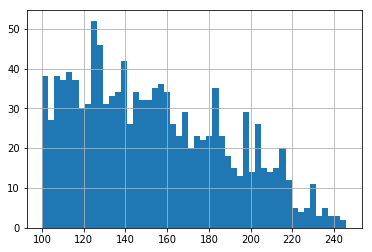

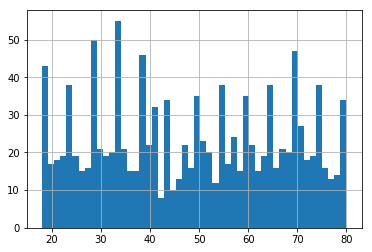

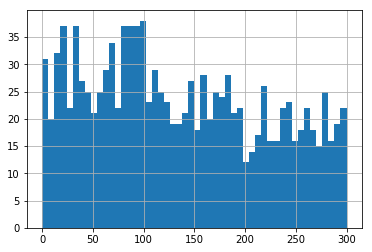

In [6]:
df['weight'].hist(bins=50);
plt.show(block=False)
df['age'].hist(bins=50);
plt.show(block=False)
df['exercise_time'].hist(bins=50)

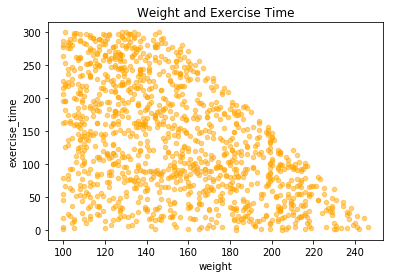

In [7]:
df.plot.scatter(x='weight', y='exercise_time', title='Weight and Exercise Time', 
                color='orange', alpha = 0.5);

# It seems like there's no relationship until the weight starts 
# to climb a little higher. Then it starts to lessen the more 
# weight the person has. Perhaps we can infer it is either harder
# or they just don't want to or don't like to exercise

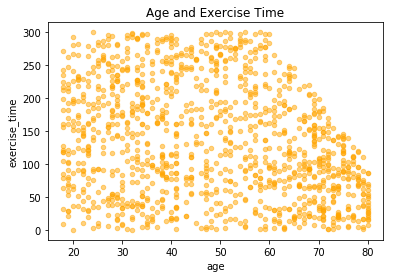

In [8]:
df.plot.scatter(x='age', y='exercise_time', title='Age and Exercise Time', 
               color = 'orange', alpha = 0.5);

# simliar trend here... the older they get, the less they exercise

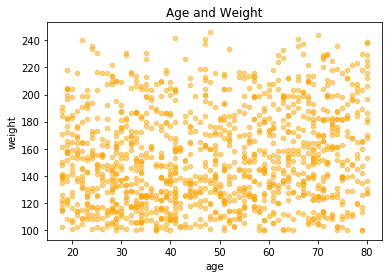

In [9]:
df.plot.scatter(x='age', y='weight', title='Age and Weight', 
               color = 'orange', alpha = 0.5);

# There doesn't seem to be any correlation here at all.

[]

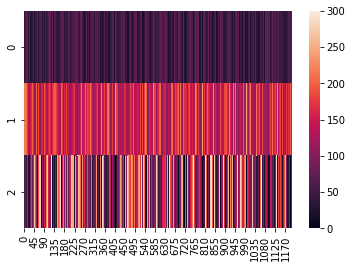

In [17]:
heat = [df['age'], df['weight'], df['exercise_time']]
sns.heatmap(heat)
plt.plot()

# not super helpful

In [0]:
from mpl_toolkits import mplot3d

Text(0.5, 0, 'Exercise Time')

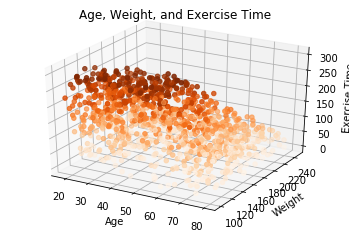

In [52]:
ax = plt.axes(projection="3d")
xdata = df['age']
ydata = df['weight']
zdata = df['exercise_time']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Oranges')
ax.set_title('Age, Weight, and Exercise Time')
ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.set_zlabel('Exercise Time')

Text(0.5, 0, 'Exercise_Time')

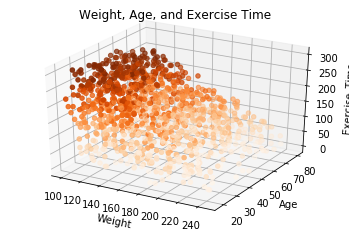

In [51]:
ax = plt.axes(projection='3d')
xdata = df['weight']
ydata = df['age']
zdata = df['exercise_time']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Oranges')
ax.set_title('Weight, Age, and Exercise Time')
ax.set_xlabel('Weight')
ax.set_ylabel('Age')
ax.set_zlabel('Exercise_Time')

Text(0.5, 0, 'Weight')

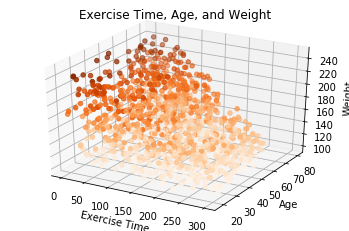

In [50]:
ax = plt.axes(projection='3d')
xdata = df['exercise_time']
ydata = df['age']
zdata = df['weight']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Oranges')
ax.set_title('Exercise Time, Age, and Weight')
ax.set_xlabel('Exercise Time')
ax.set_ylabel('Age')
ax.set_zlabel('Weight')

Text(0.5, 0, 'Age')

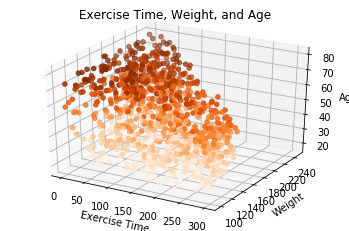

In [49]:
ax = plt.axes(projection='3d')
xdata = df['exercise_time']
ydata = df['weight']
zdata = df['age']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Oranges')
ax.set_title('Exercise Time, Weight, and Age')
ax.set_xlabel('Exercise Time')
ax.set_ylabel('Weight')
ax.set_zlabel('Age')

# this is likely the most helpful graph. It shows that both weight and age are 
# a factor in the exercise time spent. The higher the weight the lower the time,
# the higher the age, the lower the time. 

Text(0.5, 0, 'Age')

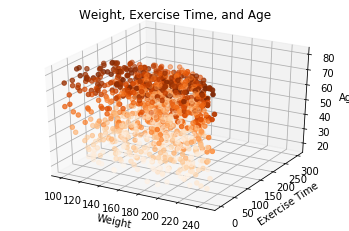

In [56]:
ax = plt.axes(projection='3d')
xdata = df['weight']
ydata = df['exercise_time']
zdata = df['age']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Oranges')
ax.set_title('Weight, Exercise Time, and Age')
ax.set_xlabel('Weight')
ax.set_ylabel('Exercise Time')
ax.set_zlabel('Age')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
Unnamed: 0       1200 non-null int64
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(4)
memory usage: 37.6 KB


In [11]:
df['exercise_time'].value_counts()

93     12
21     12
17     11
96     11
219    10
147    10
103     9
89      9
67      9
80      9
110     8
170     8
31      8
87      8
30      7
54      7
22      7
160     7
117     7
115     7
194     7
65      7
161     7
35      7
66      7
182     7
69      7
36      7
91      7
100     7
       ..
155     2
157     2
186     2
0       2
166     2
167     1
233     1
294     1
290     1
286     1
202     1
283     1
7       1
114     1
275     1
272     1
11      1
271     1
269     1
58      1
39      1
255     1
253     1
251     1
177     1
204     1
168     1
60      1
237     1
268     1
Name: exercise_time, Length: 294, dtype: int64

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)